# Assignment 1


### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import string
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier

## 1.Data Preparation

### 1) Data Preprocessing


In [2]:
#Loading dataset
data = pd.read_csv('amazon_reviews.csv')

# lowercase every string and remove punctuations alongwith numbers
data.dropna()
data['reviewText'] = data['reviewText'].str.lower()
data["reviewText"] = data['reviewText'].str.replace('[^\w\s]','')
data["reviewText"] = data['reviewText'].str.replace('[\d+]','')
data["reviewText"] = data['reviewText'].str.replace('[\d+\.]','')

# tokenize reviews where overall = 1,2,3 is 0 (negative) and overall = 4,5 is 1 (positive)
data.loc[data['overall'] <=3, 'overall'] = 0
data.loc[data['overall'] >3, 'overall'] = 1

C:\Users\monar\AppData\Local\Temp\ipykernel_13776\890867785.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data["reviewText"] = data['reviewText'].str.replace('[^\w\s]','')
C:\Users\monar\AppData\Local\Temp\ipykernel_13776\890867785.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data["reviewText"] = data['reviewText'].str.replace('[\d+]','')
C:\Users\monar\AppData\Local\Temp\ipykernel_13776\890867785.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data["reviewText"] = data['reviewText'].str.replace('[\d+\.]','')


In [3]:
# splitting the data in each row into list of words

for i, item in enumerate(data['reviewText']):
    try:
        data['reviewText'][i] = item.split()
    except:
        data.drop(i, inplace = True)

C:\Users\monar\AppData\Local\Temp\ipykernel_13776\3013012916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['reviewText'][i] = item.split()
C:\Users\monar\AppData\Local\Temp\ipykernel_13776\3013012916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['reviewText'][i] = item.split()


### 2) Data Splitting


In [4]:
X = data.iloc[:,1]
y = data.iloc[:,0]

#splitting data using sklearn into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.2, shuffle=True)

### 3) Data statistics

In [5]:
train_count = len(X_train)
train_count

3931

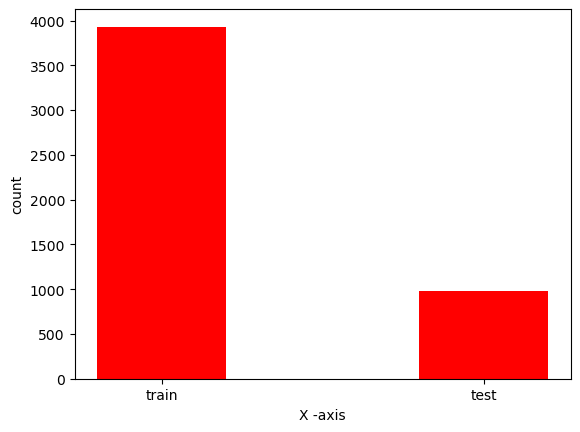

In [6]:
train_count, test_count = len(X_train), len(X_test)
Y_axis = [train_count] + [test_count]
X_axis = ['train','test']
plt.bar(X_axis, Y_axis, color ='red',
        width = 0.4)

plt.xlabel('X -axis')
plt.ylabel('count')
plt.show()

### we can see from the graph that train test split is in 80:20 ratio

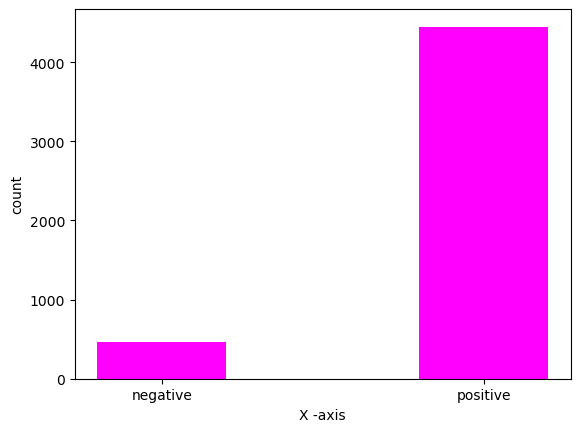

In [7]:
a = data[data['overall'] == 0].count()
b = data[data['overall'] == 1].count()

Y_axis = [a[0], b[0]]
X_axis = ['negative','positive']
plt.bar(X_axis, Y_axis, color ='magenta',
        width = 0.4)

plt.xlabel('X -axis')
plt.ylabel('count')
plt.show()

### We have far more positive samples than negative

## 2. Representation of Texts: word vectors

### 1) Count-based word vectors with co-occurrence matrix

### a) Please implement a function named get_vacab(corpus) that returns corpus_words, which is the list of all the distinct words used in the review corpus. You can do this with ‘for’ loops, but it's more efficient to do it with Python list comprehensions. The returned corpus_words should be sorted.

In [8]:
def get_vacab(corpus):
    l = len(corpus)
    if type(corpus[0]) == list:
        flattened_list = [y for x in corpus for y in x]   #flatten the corpus into one list
        final = list(set(flattened_list))                 # remove duplicate terms
        final.sort()                                      # sort the list in alphabetical order
    else:
        final = list(set(corpus))
        final.sort()
    return final

In [9]:
corpus = list(data['reviewText'])
corpus

[['no', 'issues'],
 ['purchased',
  'this',
  'for',
  'my',
  'device',
  'it',
  'worked',
  'as',
  'advertised',
  'you',
  'can',
  'never',
  'have',
  'too',
  'much',
  'phone',
  'memory',
  'since',
  'i',
  'download',
  'a',
  'lot',
  'of',
  'stuff',
  'this',
  'was',
  'a',
  'no',
  'brainer',
  'for',
  'me'],
 ['it',
  'works',
  'as',
  'expected',
  'i',
  'should',
  'have',
  'sprung',
  'for',
  'the',
  'higher',
  'capacity',
  'i',
  'think',
  'its',
  'made',
  'a',
  'bit',
  'cheesier',
  'than',
  'the',
  'earlier',
  'versions',
  'the',
  'paint',
  'looks',
  'not',
  'as',
  'clean',
  'as',
  'before'],
 ['this',
  'think',
  'has',
  'worked',
  'out',
  'greathad',
  'a',
  'diff',
  'bran',
  'gb',
  'card',
  'and',
  'if',
  'went',
  'south',
  'after',
  'monthsthis',
  'one',
  'has',
  'held',
  'up',
  'pretty',
  'well',
  'since',
  'i',
  'had',
  'my',
  's',
  'now',
  'on',
  'my',
  'note',
  'update',
  'ive',
  'had',
  'this',
 

In [10]:
vocab = get_vacab(corpus)


### b) Based on the word vocabulary obtained with get_vacab(corpus) function, please implement a function named compute_co_occurrence_matrix(corpus, window_size=4) that returns both M and word2index. Here, M is the co-occurrence matrix of word counts and word2index is a dictionary that maps word to index.

In [11]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    vocab = get_vacab(corpus)
    word2index = {word: index for index,word in enumerate(vocab)}  # dictionary comprehension for word to index
    
    M = np.zeros([len(vocab),len(vocab)])          #initialize the matrix with zeros
    
    for sentence in corpus:
        for i,word in enumerate(sentence):
            
            # define start and end points of the window respective to window size such that we don't run out of bounds
            window_start = max(0, i - window_size)
            window_end = min(len(sentence), i + window_size +1)
            
            for j in range(window_start,window_end):
                if j != i:
                    try:
                        req_word = sentence[j]
                        if req_word in vocab:
                            M[word2index[word]][word2index[sentence[j]]] += 1 # populates the co-occurence matrix, increasing by 1 count
                    except:
                        pass
                            
    return M, word2index
            

In [12]:
m, w = compute_co_occurrence_matrix(corpus, window_size=4)  #run compute_co_occurrence_matrix function on our corpus with window size 4

### c) Please implement a function named reduce_to_k_dim(M) performs dimensionality reduction on the matrix M to produce k-dimensional embeddings and returns the new matrix M_reduced. 

In [13]:
def reduce_to_k_dim(M, k):
    svd = TruncatedSVD(n_components=k, n_iter=10)      #use svd from sklearn
    M_reduced = svd.fit_transform(M)
    
    #return matrix with reduced dimensions
    return M_reduced        
    


In [30]:
m_reduced = reduce_to_k_dim(m, k=2)
m_reduced


array([[ 8.35783164e-02, -9.15364542e-05],
       [ 1.46921119e-01,  1.38115234e-01],
       [ 3.53704506e+03,  8.75451501e+02],
       ...,
       [ 7.53917590e-01,  1.39473315e-01],
       [ 1.31791559e+00, -6.03577878e-01],
       [ 1.29829091e+00, -3.14356691e-01]])

### d) Implement plot_embeddings(M_reduced, word2index, words_to_plot) to plot in a scatterplot the embeddings of the words specified in the list ‘words_to_plot’. Here, ‘M_reduced’ is the matrix of 2-dimensional word embeddings obtained in question c. word2index is the dictionary that maps words to indices for the embedding matrix obtained in question b. Use the implemented function to get the plot for the following list of words_to_plot=[‘purchase’, ‘buy’, ‘work’, ‘got’, ‘ordered’, ‘received’, ‘product’, ‘item’, ‘deal’, ‘use’], and show the plot.

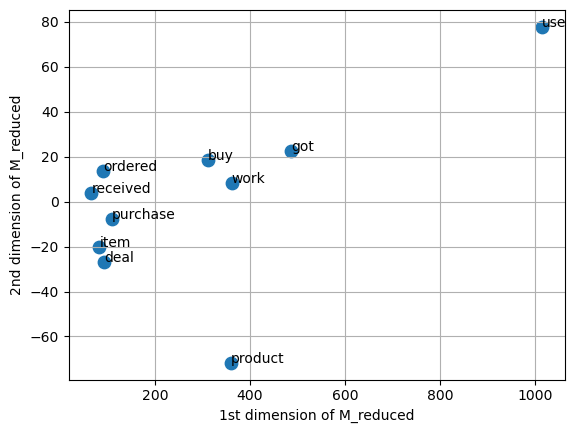

In [15]:
def plot_embeddings(M_reduced, word2index, words_to_plot):
    
    # derive indices to plot from words to plot
    plot_indices = []
    for i in words_to_plot:
        if i in word2index:
            plot_indices.append(word2index[i])
            

    # map the embeddings from word2index to M_reduced
    plot_embeddings = M_reduced[plot_indices]

    
    plt.scatter(plot_embeddings[:, 0], plot_embeddings[:, 1], s=80)

    # map words to points on the plot
    for i, word in enumerate(words_to_plot):
        plt.annotate(word, (plot_embeddings[i, 0], plot_embeddings[i, 1]))

    plt.xlabel('1st dimension of M_reduced')
    plt.ylabel('2nd dimension of M_reduced')


    plt.grid(True)
    plt.show()

    
words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']

plot_embeddings(m_reduced, w, words_to_plot)


## 2) Prediction-based word vectors from Glove

### a) Please use the provided load_embedding_model() function to load the GloVe embeddings. 

In [16]:
def load_embedding_model():
    """ Load GloVe Vectors
    Return:
    wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


### b) Select the words in the vocabulary returned in 1)a and get the corresponding GloVe vectors. You can adapt the provided function get_matrix_of_vectors(wv_from_bin, required_words) to select the Glove vectors and put them in a matrix M.

In [17]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind


In [18]:
M_glove, word2ind_glove = get_matrix_of_vectors(wv_from_bin, vocab)

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.


### c) Use the function reduce_to_k_dim() you implemented in 1)c to reduce the vectors to 2 dimension. Similar to what you did in 1)c.

In [19]:
M_glove_reduced = reduce_to_k_dim(M_glove, k = 2)

### d) Use the plot_embeddings function in 1)d to get the plot for the same set of words in 1)d. Compare the differences of the plot in 1)d and 2)d, provide some analysis, and describe your findings.

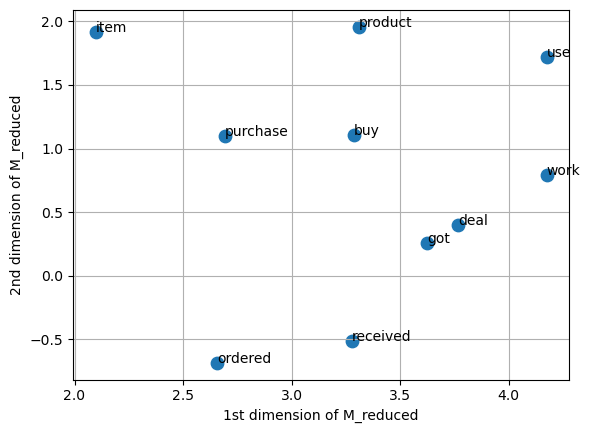

In [20]:
plot_embeddings(M_glove_reduced, word2ind_glove, words_to_plot)

### We can see that scatter plot is more sparse in 2)d then it was in 1)d. 
### Also, the embeddings with similar meanings are in the same level of the scatterplot. For eg. item and product; purchase and buy; ordered and received

## 3. Perform sentiment analysis with classification

### 1) Review embeddings: Similar to what you did in 2)c, use the function reduce_to_k_dim() you implemented in 1)c to reduce the vectors to 128 dimension. Based on the word embeddings, get the review embedding by taking the average of the word embeddings in each review. Write a function for getting review embeddings for each review.

In [21]:

# educe the dimensions of m to 128
M_128 = reduce_to_k_dim(m, k = 128)

def get_review_embeddings(reviews, M, word2index):
    
    # initialize list of review embeddings
    rev_embeddings = []
    
    for i in reviews:
        temp_list = []
        
        for j in i:
            if j in word2index:
                temp_list.append(M[word2index[j]])  # append the temp list if the word at counter j is in word2index
        
        if len(temp_list) != 0:
            rev_embeddings.append(np.mean(temp_list, axis = 0))   # update review embeddings list with mean value
        else:
            rev_embeddings.append(np.zeros(128))  # if word is not present fill in with zero
    
    return rev_embeddings
        
    

In [22]:

rev = get_review_embeddings(corpus, M_128,w)

### 2) Models: Please examine the performance of the following two models on the sentiment analysis task. You can use existing implementations of the models and various packages such as sklearn, Tensorflow, Pytorch, etc.

### a) Logistic Regression

In [23]:
logistic_regression_model = LogisticRegression() #initialize logistic regression from sklearn

# process training and testing data
corpus_train = list(X_train)
corpus_test = list(X_test)

# get vocab of train and test data
vocab_train = get_vacab(corpus_train)
vocab_test = get_vacab(corpus_test)

# compute co occurence matrix and word2index for train and test data
m_train, w_train = compute_co_occurrence_matrix(vocab_train, window_size=4)
m_test, w_test = compute_co_occurrence_matrix(vocab_test, window_size=4)

# reduce dimensions of the matrices to 128
m_train_128 = reduce_to_k_dim(m_train, k =128)
m_test_128 = reduce_to_k_dim(m_test, k =128)

# process data to train model
rev_train = get_review_embeddings(corpus_train, m_train_128,w_train)
rev_test = get_review_embeddings(corpus_test, m_test_128,w_test)

# test model
logistic_regression_model.fit(rev_train, y_train)
predict_lr = logistic_regression_model.predict(rev_test)



C:\Users\monar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### b) Neural Network (NN) model


In [24]:
# initialize Neural Network model
NN_model = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

# train model and test
NN_model.fit(rev_train, y_train)

predict_NN = NN_model.predict(rev_test)



### 3) Evaluation 

### a) Evaluate the model performance using metrics for classification, such as accuracy, precision, recall, F1-score, and AUC. Report your results for both methods

In [25]:
# report for logistic regression 
report_lr = classification_report(y_test, predict_lr)

print(report_lr)


              precision    recall  f1-score   support

           0       0.08      0.16      0.11        89
           1       0.91      0.82      0.86       894

    accuracy                           0.76       983
   macro avg       0.49      0.49      0.49       983
weighted avg       0.83      0.76      0.80       983



In [26]:
# report for neural network model
report_NN = classification_report(y_test, predict_NN)

print(report_NN)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.91      1.00      0.95       894

    accuracy                           0.91       983
   macro avg       0.45      0.50      0.48       983
weighted avg       0.83      0.91      0.87       983



C:\Users\monar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\monar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\monar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### b) Have a brief discussion to compare the performance of those two models (5 points). It should be noted that there is no fixed answer for the results. You will need to report the exact results returned in your experiments.

### We can see that the accuracy of NN model is much higher than LR model. This might be due to patterns in the words that are not learnable by linear models. 